<a href="https://colab.research.google.com/github/stratoskar/Path-Based-Traffic-Flow-Prediction/blob/main/Python_Code/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

We remind you that the SPQ rules are fully described [here](https://dl.acm.org/doi/abs/10.1145/2666310.2666413)

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Thesis/traffic_flow_SPQ.csv'

#### **Prepare the dataset**

We use the necessary code to convert our time series dataframe into more usefull one.

In [4]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it's the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-05-30 00:00:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [5]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-05-29 19:00:04,2008-05-29 19:30:04,2008-05-29 20:00:04,2008-05-29 20:30:04,2008-05-29 21:00:04,2008-05-29 21:30:04,2008-05-29 22:00:04,2008-05-29 22:30:04,2008-05-29 23:00:04,2008-05-29 23:30:04
0,59,519,"[746808402, 512523366, 417094961, 417094961, 9...",14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,283,407,"[254984059, 24203860, 24203860, 85562608, 8556...",20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

Convert 'Path' column to numerical

In [7]:
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [8]:
# Define the path of weather data
path2 = '/content/drive/MyDrive/Paper/Datasets/Weather Data/weather_data.csv'

# Read weather data
weather_data = pd.read_csv(path2,sep=',')

# Drop unecessary columns
# Dropped columns can either have NaN values, or not be associated with traffic flow.
# Columns kept: temperature, humidity, windspeed, sealevelpressure, visibility
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

In [9]:
# View the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            142
Rain, Overcast        1
Name: conditions, dtype: int64

In [10]:
# Change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

In [11]:
# view again the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            143
Name: conditions, dtype: int64

In [12]:
# One-Hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# Concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

In [13]:
# View for null values
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     744 non-null    object 
 1   temp                         744 non-null    float64
 2   humidity                     744 non-null    float64
 3   windspeed                    744 non-null    float64
 4   sealevelpressure             744 non-null    float64
 5   visibility                   744 non-null    float64
 6   conditions_Clear             744 non-null    uint8  
 7   conditions_Overcast          744 non-null    uint8  
 8   conditions_Partially cloudy  744 non-null    uint8  
dtypes: float64(5), object(1), uint8(3)
memory usage: 37.2+ KB


There are not null values in the weather dataset.

In [14]:
# Convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

In [15]:
# Connect two dataframes, time-series traffic flow and weather data
traffic_flow.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

In [16]:
# Resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# Add 4 seconds to each timestamp
weather_data.index = weather_data.index + pd.to_timedelta(4, unit='s')

In [17]:
# Merge the 'traffic_flow' and 'weather_data' datasets based on their indexes
traffic_flow = traffic_flow.merge(weather_data, left_index=True, right_index=True)

In [18]:
# Reset index and rename index column
traffic_flow = traffic_flow.reset_index()
traffic_flow.rename(columns={'index': 'Time Column'}, inplace=True)

In [19]:
# Print dataframe
traffic_flow

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,visibility,conditions_Clear,conditions_Overcast,conditions_Partially cloudy
0,2008-05-17 10:00:04,108,56,0,4,6,21.4,54.07,12.1,1019.8,16.0,0,0,1
1,2008-05-17 10:00:04,195,734,1,2,4,21.4,54.07,12.1,1019.8,16.0,0,0,1
2,2008-05-17 10:00:04,411,168,2,19,2,21.4,54.07,12.1,1019.8,16.0,0,0,1
3,2008-05-17 10:00:04,150,147,3,2,4,21.4,54.07,12.1,1019.8,16.0,0,0,1
4,2008-05-17 10:00:04,474,439,4,11,13,21.4,54.07,12.1,1019.8,16.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603995,2008-05-29 23:30:04,365,438,995,4,5,13.2,75.04,14.2,1019.8,16.0,0,1,0
603996,2008-05-29 23:30:04,150,179,996,2,29,13.2,75.04,14.2,1019.8,16.0,0,1,0
603997,2008-05-29 23:30:04,260,230,997,18,0,13.2,75.04,14.2,1019.8,16.0,0,1,0
603998,2008-05-29 23:30:04,303,106,998,15,0,13.2,75.04,14.2,1019.8,16.0,0,1,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [20]:
### Extract timestamp information to different columns ###

traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###

traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [21]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [22]:
# Print traffic_flow dataframe
traffic_flow

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,108,56,0,4,6,21.4,54.07,12.1,1019.8,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
1,2008-05-17 10:00:04,195,734,1,2,4,21.4,54.07,12.1,1019.8,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
2,2008-05-17 10:00:04,411,168,2,19,2,21.4,54.07,12.1,1019.8,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
3,2008-05-17 10:00:04,150,147,3,2,4,21.4,54.07,12.1,1019.8,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
4,2008-05-17 10:00:04,474,439,4,11,13,21.4,54.07,12.1,1019.8,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603995,2008-05-29 23:30:04,365,438,995,4,5,13.2,75.04,14.2,1019.8,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603996,2008-05-29 23:30:04,150,179,996,2,29,13.2,75.04,14.2,1019.8,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603997,2008-05-29 23:30:04,260,230,997,18,0,13.2,75.04,14.2,1019.8,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603998,2008-05-29 23:30:04,303,106,998,15,0,13.2,75.04,14.2,1019.8,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8


#### **Make Visualizations**

Here, we are doing the following operations:
- View mean traffic flow (average number of traffic flow using every path in the dataset) per timestep. In this way, we can understand patterns that traffic flow has.

- Compute average total traffic flow per 3-hour interval, to understand in which time of each day Traffic Flow is on its peak.

- Find correlations among columns in the dataset.

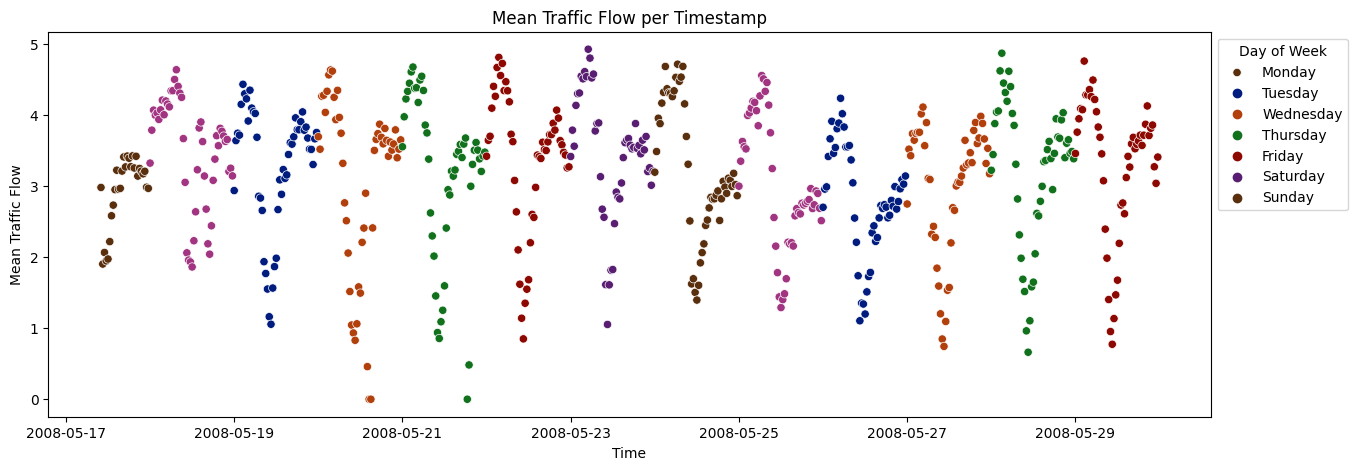

In [79]:
# Group by timestamp and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['Time Column']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Add additional time information in the dataset
grouped_df['hour'] = grouped_df.index.hour
grouped_df['3hour_interval'] = grouped_df['hour'].apply(get_3hour_interval)
grouped_df['dayofweek'] = grouped_df.index.dayofweek

# Create a custom dark color palette
dark_palette = sns.color_palette('dark')

# Create a plot to view the results
plt.figure(figsize=(15,5))
sns.scatterplot(grouped_df,x=grouped_df.index,y='Traffic Flow',hue='dayofweek',marker='o', palette=dark_palette)
plt.xlabel('Time')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Timestamp')

# Set the legend title.
plt.legend(title='Day of Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],bbox_to_anchor=(1, 1), loc='upper left')

# Show graph
plt.show()

This scatterplot shows us the mean traffic flow levels per day and per specific timestamp.

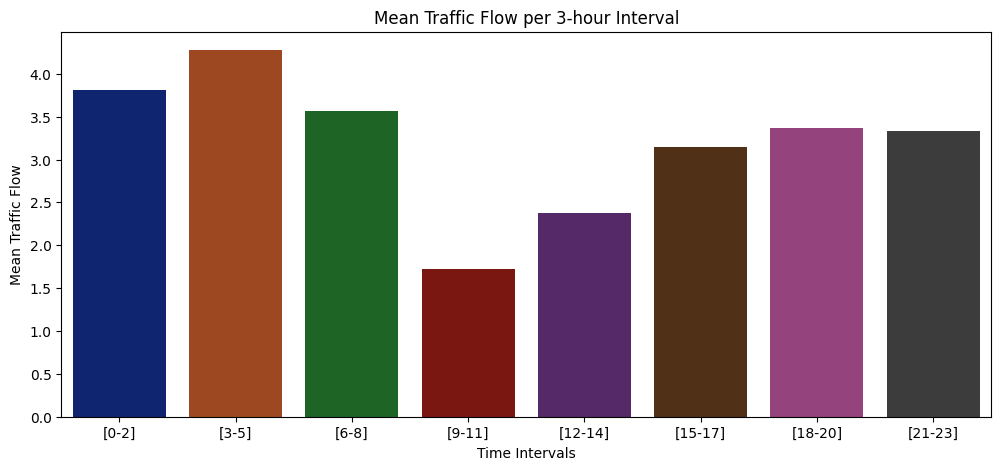

In [24]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a custom dark color palette
dark_palette = sns.color_palette('dark')

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', palette=dark_palette)
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during the noon period.

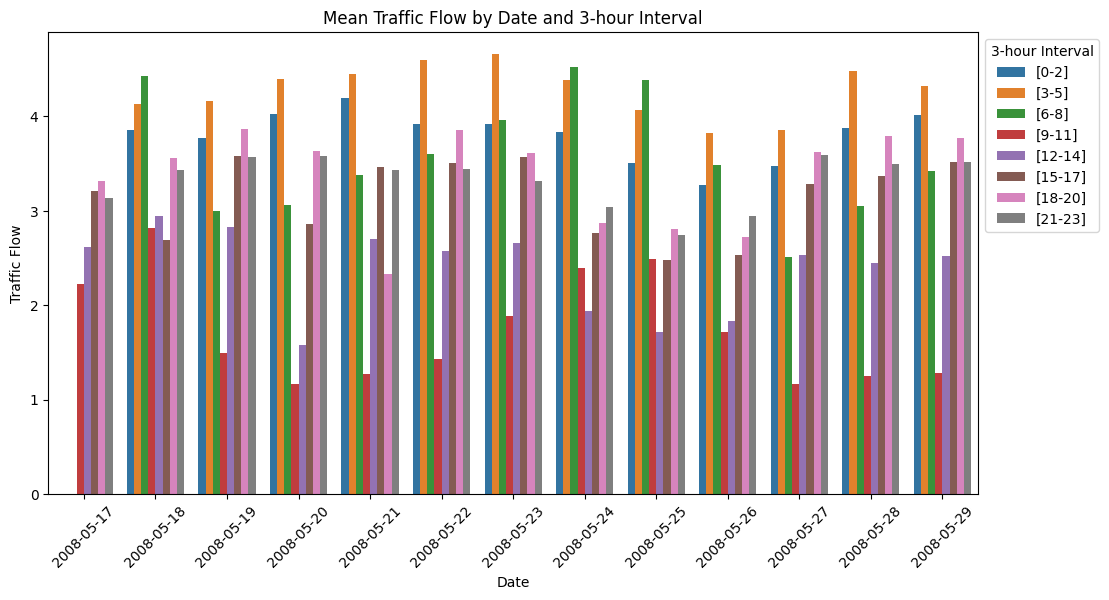

In [25]:
df = traffic_flow.copy()

# Extract the date from the 'Time Column' and create a new column 'Date'
df['Date'] = df['Time Column'].dt.date

# Group the dataframe by 'Date' and '3hour_interval' and calculate the 'Traffic Flow' for each group
new_df = df.groupby(['Date', '3hour_interval'])['Traffic Flow'].mean().reset_index()

# Map the '3hour_interval' values to custom labels using a dictionary
interval_labels = {1: '[0-2]', 2: '[3-5]', 3: '[6-8]', 4: '[9-11]', 5: '[12-14]', 6: '[15-17]', 7: '[18-20]', 8: '[21-23]'}
new_df['3hour_interval_label'] = new_df['3hour_interval'].map(interval_labels)

# Create a Seaborn bar plot with stacked bars, specifying the order of the legend
plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='Traffic Flow', hue='3hour_interval_label', data=new_df, hue_order=interval_labels.values())

# Add title and axis labels
plt.title('Mean Traffic Flow by Date and 3-hour Interval')
plt.xlabel('Date')
plt.ylabel('Traffic Flow')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a specified title and position
plt.legend(title='3-hour Interval', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

Traffic Flow is at its peak at dawn: from 3 to five o'clock in the morning. The lowest traffic flow volumes are usually during 9 and 11 o'clock in the morning, according to the data.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

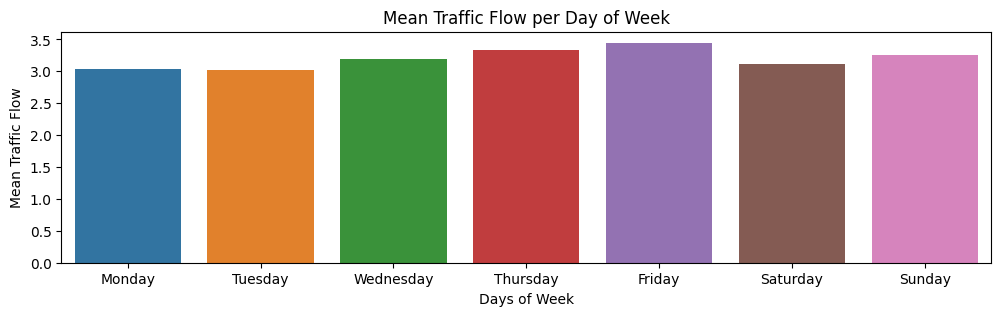

In [26]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

According to the plot above, the average traffic flow throughout the weekdays appears to be nearly uniform. However, Thursdays and Fridays exhibit a higher average traffic flow, while the remaining days also adhere to similar patterns.

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

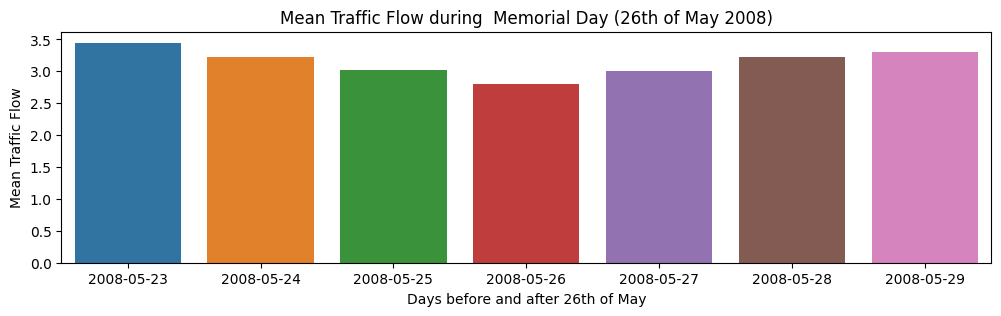

In [27]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

Text(0, 0.5, 'Mean Traffic Flow')

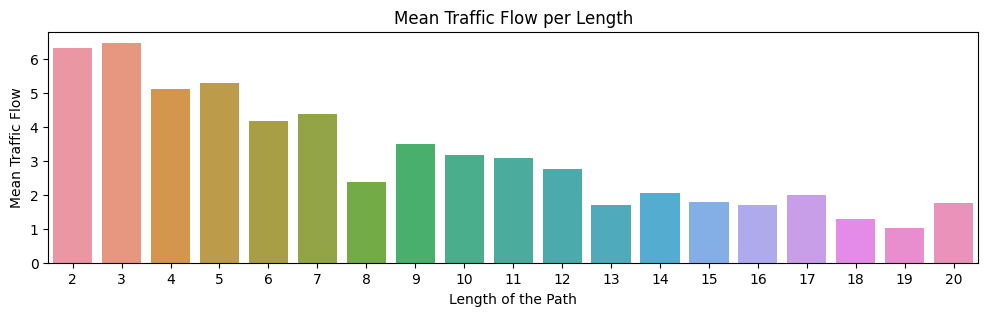

In [28]:
# Create a DataFrame by grouping 'Traffic Flow' by 'Length' and calculating the mean
group_by_length = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['Length']).mean())

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(group_by_length,x=group_by_length.index,y='Traffic Flow')
plt.xlabel('Length of the Path')
plt.title('Mean Traffic Flow per Length')
plt.ylabel('Mean Traffic Flow')

The graph illustrates a trend where traffic flow tends to decrease with an increase in the length of the path. This pattern is expected, as a greater number of edges in a path makes it more challenging for a Yellow Taxi to precisely navigate that specific route.

Remember that the distribution of path lengths is uniform.

Text(0, 0.5, 'Mean Traffic Flow')

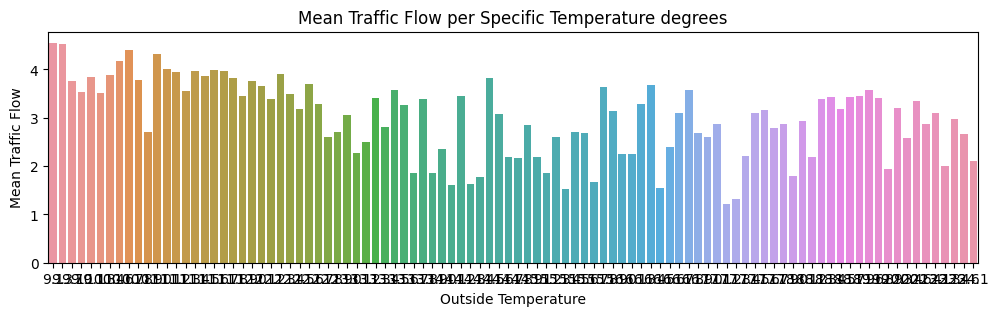

In [78]:
# Create a DataFrame by grouping 'Traffic Flow' by 'hour' and calculating the mean
group_by_length = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['temp']).mean())

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(group_by_length,x=group_by_length.index,y='Traffic Flow')
plt.xlabel('Outside Temperature')
plt.title('Mean Traffic Flow per Specific Temperature degrees')
plt.ylabel('Mean Traffic Flow')

<Axes: >

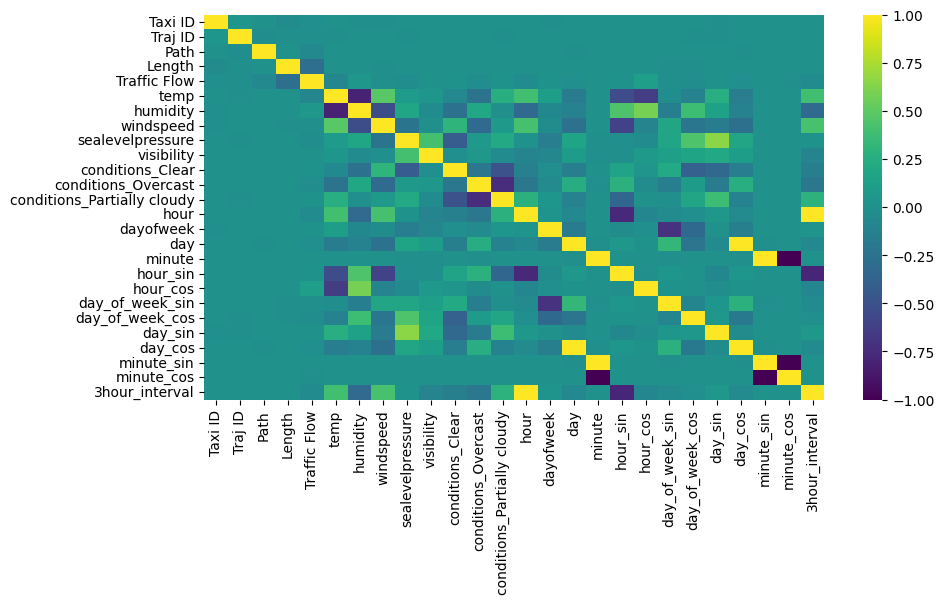

In [29]:
# Find highly correlated data in the traffic flow dataset
plt.figure(figsize=(10,5))
sns.heatmap(traffic_flow.corr(), annot=False, cmap='viridis')

Based on the heatmap above, we can see that there is a strong correlation between the:

*  minute_cos and minute attributes
*  hour_sin and 3hour_interval
*  hour and 3hour_interval
*  hour_sin and hour
*  dayofweek and day_of_week_sin
*  dayofweek and day_of_week_cos
*  day and day_sin
*  minute and minute_sin
*  minute_cos and minute_sin

So, due to the fact that these features are highly correlated, the information they share is almost the same. So, we can drop the following features, to create a simpler model: minute, day, 3hour_interval, dayofweek and hour.








#### **Tune XGBoost model**


In [30]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-05-29 23:30:04


**Train and Test split of the dataset**

In this step, we split the data into two datasets, train and test.
- Train dataset contains all the data for each path till 08-06-2008 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [31]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [32]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

# Print the results
print("Traffic flow train set shape: ",train.shape)
print("Traffic flow test set shape: ",test.shape)

Traffic flow train set shape:  (556000, 27)
Traffic flow test set shape:  (48000, 27)


In [33]:
# Redefine train and test sets based on correlated features (drop highly correlated features)
train = train.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)
test = test.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)

**Find the best lookback timesteps for our XGBoost model**

In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

In [34]:
# Find best lookback timesteps to perform analysis on traffic_flow dataset. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [35]:
import pandas as pd

def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problems with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters.
- 3. Predict on the test set.
- 4. Save RMSE in a dataframe.

In [36]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
for lookback in [2, 3, 4, 5, 6]:  # Use different lookback sizes

    # Convert train and test data to supervised
    train_s = generate_X_y_pairs(train, lookback)
    test_s = generate_X_y_pairs(test, lookback)

    print("Lookback = " + str(lookback) + " - To supervised: Completed!")

    # Add rolling mean information
    train_s['rolling_mean'] = train_s.iloc[:, 0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:, 0:lookback].mean(axis=1)

    # Define features
    features_s = train_s.drop(['Traffic Flow', 'Record 1(t)', 'Time Column'], axis=1).columns

    # Define label
    labels_s = ['Record 1(t)']

    # Create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # Create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = " + str(lookback) + " - Train and Test sets: Completed!")

    # Define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, early_stopping_rounds=5)

    # Train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s, y_test_s)], verbose=False)

    print("Lookback = " + str(lookback) + " - Training: Completed!")

    # Make predictions
    y_pred_s = reg.predict(X_test_s)

    # Calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # Create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # Append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = " + str(lookback) + " - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Training: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Training: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Training: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Training: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Training: Completed!
Lookback = 6 - Saved Results: Completed!


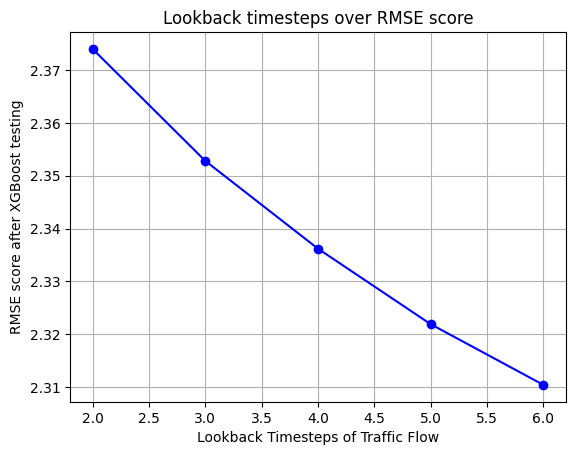

In [38]:
# Use a plot to show the results
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# Set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [39]:
# Find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

In [80]:
# Print optimum length of sliding window
print(f'Optimum length of sliding window is: {optimum_lookback}')

Optimum length of sliding window is: 6


In [41]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

**Extract features about trend of time series**

In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [42]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

**Define labels and features**

- Features will help the XGboost algorithm to predict the output value (the label). We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.

- Label will be out target value, the Traffic Flow at timestep t.

In [43]:
# Define features
features = train.drop(['Time Column','Record 1(t)','Traffic Flow','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [44]:
# Show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (550000, 27)
Shape of y_train is:  (550000, 1)
Shape of X_test is:  (42000, 27)
Shape of y_test is:  (42000, 1)


**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [45]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [46]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    "max_depth": [3,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1,1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:5.00105	validation_1-rmse:4.98222
[1]	validation_0-rmse:4.66749	validation_1-rmse:4.64696
[2]	validation_0-rmse:4.37344	validation_1-rmse:4.35112
[3]	validation_0-rmse:4.11789	validation_1-rmse:4.09490
[4]	validation_0-rmse:3.89564	validation_1-rmse:3.87223
[5]	validation_0-rmse:3.70126	validation_1-rmse:3.67605
[6]	validation_0-rmse:3.53171	validation_1-rmse:3.50644
[7]	validation_0-rmse:3.37951	validation_1-rmse:3.35370
[8]	validation_0-rmse:3.24443	validation_1-rmse:3.21869
[9]	validation_0-rmse:3.13223	validation_1-rmse:3.10670
[10]	validation_0-rmse:3.03395	validation_1-rmse:3.00866
[11]	validation_0-rmse:2.95034	validation_1-rmse:2.92457
[12]	validation_0-rmse:2.87535	validation_1-rmse:2.84981
[13]	validation_0-rmse:2.81201	validation_1-rmse:2.78671
[14]	validation_0-rmse:2.75787	validation_1-rmse:2.73254
[15]	validation_0-rmse:2.71316	validation_1-rmse:2.68887
[16]	validation_0-rmse:2.67065	valida

#### **Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [47]:
# Create dataframe to save actual values and model predictions
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Record 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

In [48]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = xgb_grid.best_params_['n_estimators'],
    alpha = xgb_grid.best_params_['alpha'],
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:4.94710	validation_1-rmse:4.92890
[1]	validation_0-rmse:4.56798	validation_1-rmse:4.54945
[2]	validation_0-rmse:4.23415	validation_1-rmse:4.21769
[3]	validation_0-rmse:3.94182	validation_1-rmse:3.92856
[4]	validation_0-rmse:3.68679	validation_1-rmse:3.67832
[5]	validation_0-rmse:3.46513	validation_1-rmse:3.46062
[6]	validation_0-rmse:3.27307	validation_1-rmse:3.27358
[7]	validation_0-rmse:3.10722	validation_1-rmse:3.11332
[8]	validation_0-rmse:2.96456	validation_1-rmse:2.97556
[9]	validation_0-rmse:2.84192	validation_1-rmse:2.86078
[10]	validation_0-rmse:2.73766	validation_1-rmse:2.76209
[11]	validation_0-rmse:2.64816	validation_1-rmse:2.68221
[12]	validation_0-rmse:2.57247	validation_1-rmse:2.61483
[13]	validation_0-rmse:2.50727	validation_1-rmse:2.55980
[14]	validation_0-rmse:2.45255	validation_1-rmse:2.51184
[15]	validation_0-rmse:2.40537	validation_1-rmse:2.47276
[16]	validation_0-rmse:2.36606	validation_1-rmse:2.44008
[17]	validation_0-rmse:2.33309	validation

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

<Figure size 1500x500 with 0 Axes>

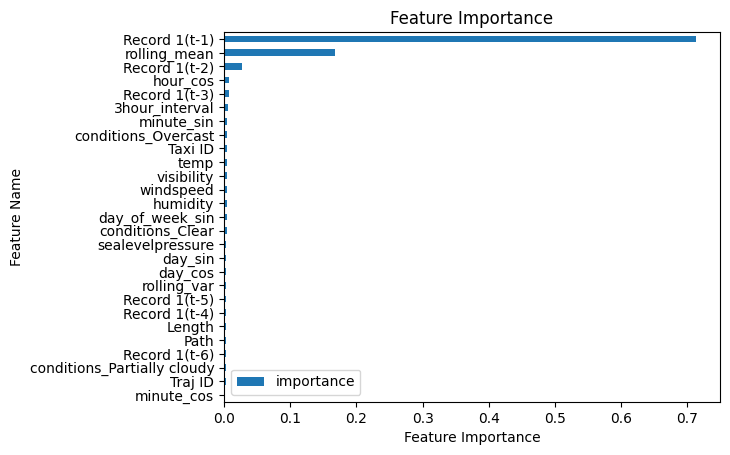

In [49]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

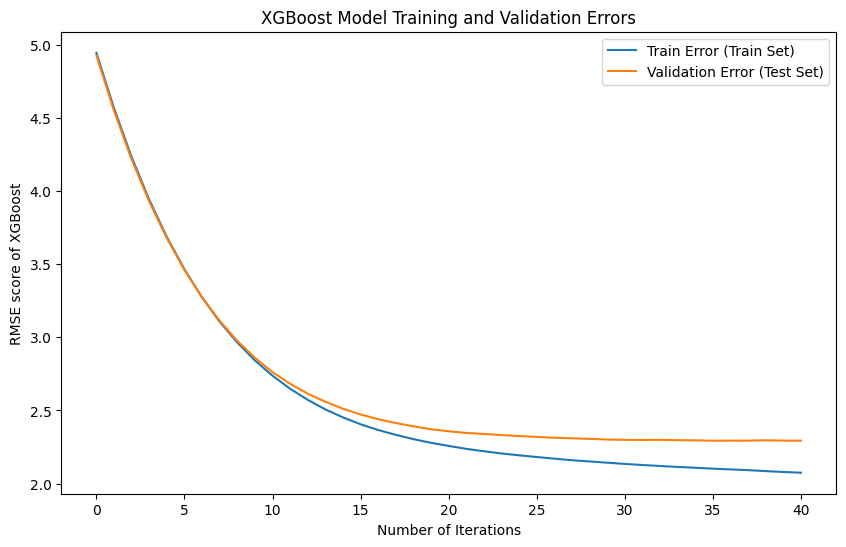

In [50]:
# Acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# Plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [51]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3765545551954281
RMSE score: 2.2929998008747594


Show example of how well the model learned the trainning data.


Use a random path to visualize the results

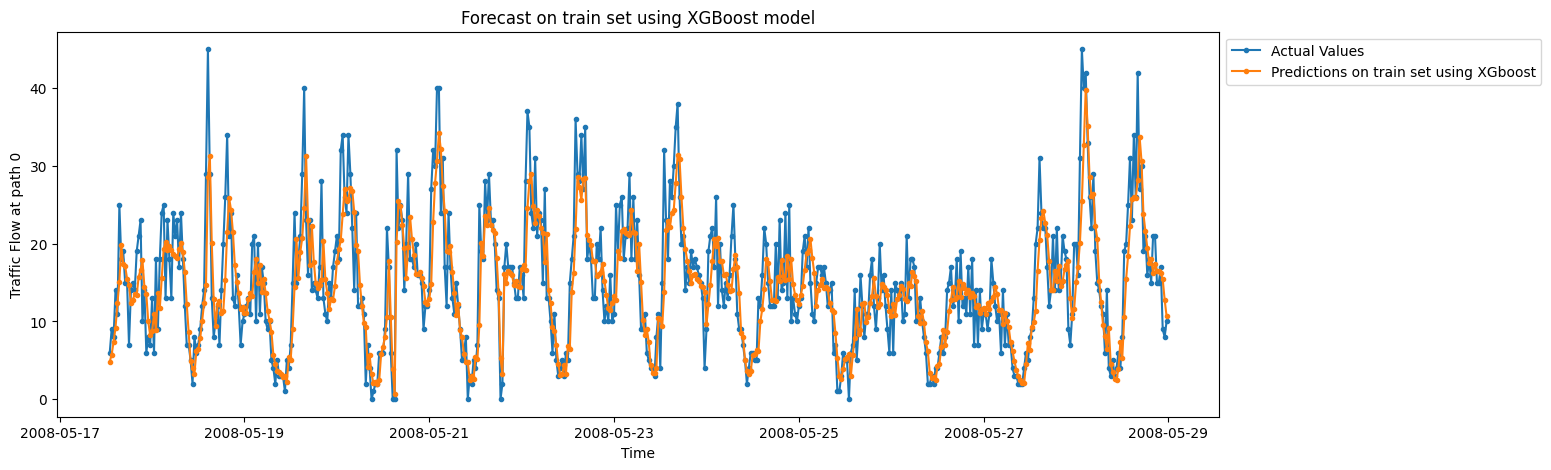

In [53]:
# Predict on the trainning set
y_pred_train = reg.predict(X_train)

# Add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Traffic Flow at path 0')
plt.title('Forecast on train set using XGBoost model')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

As we can see, the model has learned the trend and (almost) the seasonality of the data.

Despite the non-linearity of Traffic Flow, XGBoost performs quite well!

#### **Train LSTM for time series forecasting**
This is the second model that we will train on the same dataset. We use the optimum lookback score that we computed above, before training the XGboost algorithm. This ensures that the LSTM model will be trained on the same data as the XGboost algorithm.

In [54]:
# Import library for data scaling
from sklearn.preprocessing import MinMaxScaler

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [55]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [56]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [57]:
# Create 3D test set FOR LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In [58]:
# Print shapes of the created sets
trainX.shape, trainY.shape, testX.shape, testY.shape

((550000, 1, 27), (550000, 1, 1), (42000, 1, 27), (42000, 1, 1))

Use the LSTM model for forecasting

In [59]:
# Import libraries and define the LSTM structure
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [60]:
# Define LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [61]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [62]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 19s 127ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/50
100/100 [==============================] - 11s 109ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/50
100/100 [==============================] - 11s 110ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/50
100/100 [==============================] - 11s 114ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/50
100/100 [==============================] - 12s 119ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/50
100/100 [==============================] - 11s 109ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/50
100/100 [==============================] - 11s 109ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/50
100/100 [==============================] - 11s 110ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/50
100/100 [==============================] - 11s 113ms/step - l

In [63]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1313/1313 [==============================] - 5s 4ms/step - loss: 0.0014
Test Loss: 0.0014188667992129922


Plot train vs. validation loss of LSTM model

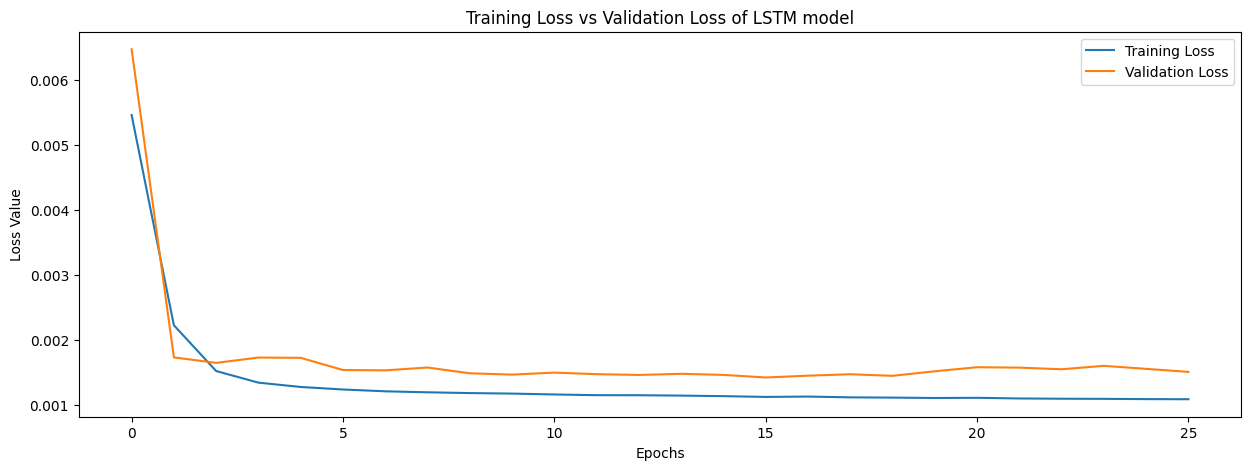

In [64]:
# Extract training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Loss vs Validation Loss of LSTM model')
plt.legend()

# Show the plot
plt.show()

In [65]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1313/1313 [==============================] - 6s 4ms/step


Evaluate the LSTM model

In [66]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4224371671357325
RMSE LSTM score: 2.41074253132179


17188/17188 [==============================] - 65s 4ms/step


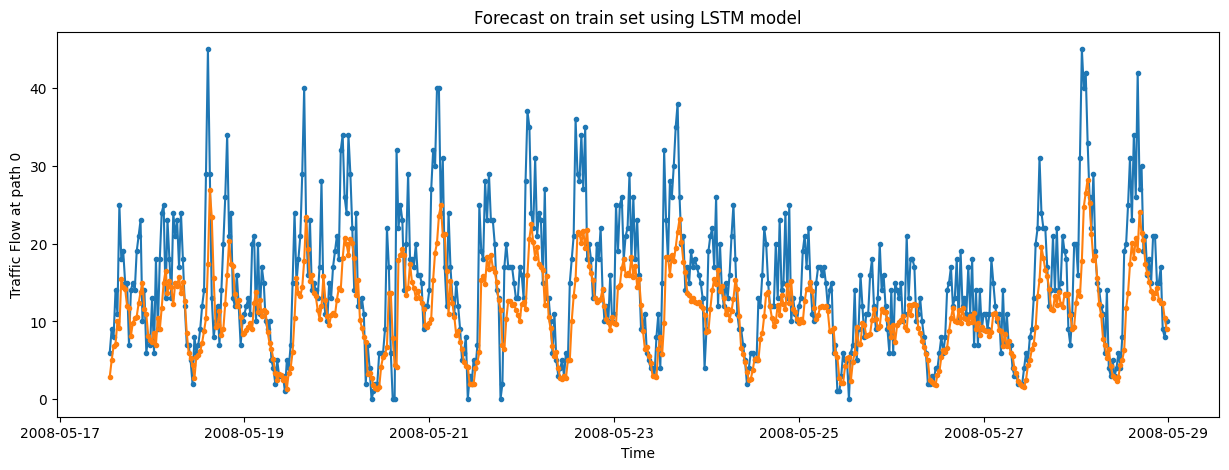

In [67]:
# Predict on the trainning set
y_pred_train_LSTM = model.predict(trainX)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',scaler.inverse_transform(y_pred_train_LSTM.reshape(-1,1)))
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow at path 0')
plt.title('Forecast on train set using LSTM model')
plt.show()

#### Show results of two models

In [68]:
# Store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [69]:
# Store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = y_pred_lstm.reshape(-1,1)

In [70]:
# Print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM
Time Column,,,,
2008-05-29 03:00:04,27.0,0,28.729429,26.844181
2008-05-29 03:30:04,18.0,0,25.867374,24.068197
2008-05-29 04:00:04,34.0,0,23.122520,19.672033
2008-05-29 04:30:04,31.0,0,26.042580,24.567192
2008-05-29 05:00:04,21.0,0,27.824783,23.587370
...,...,...,...,...
2008-05-29 21:30:04,0.0,999,2.372826,1.780833
2008-05-29 22:00:04,0.0,999,1.640532,1.385600
2008-05-29 22:30:04,1.0,999,1.551735,1.279999


[]

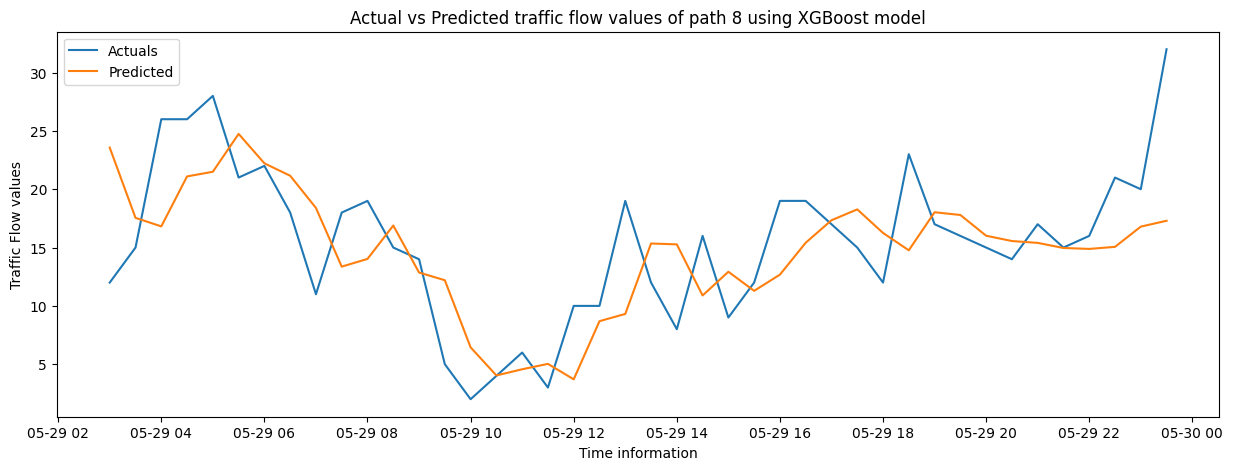

In [71]:
# Plot predictions from XGBoost model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 8 using XGBoost model')
plt.legend()
plt.plot()

[]

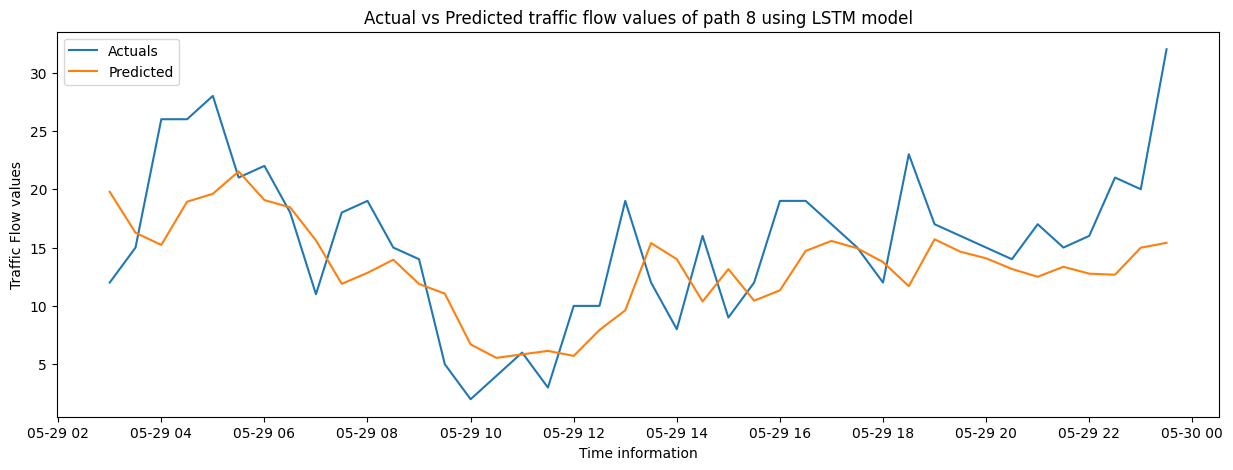

In [72]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 8 using LSTM model')
plt.legend()
plt.plot()

[]

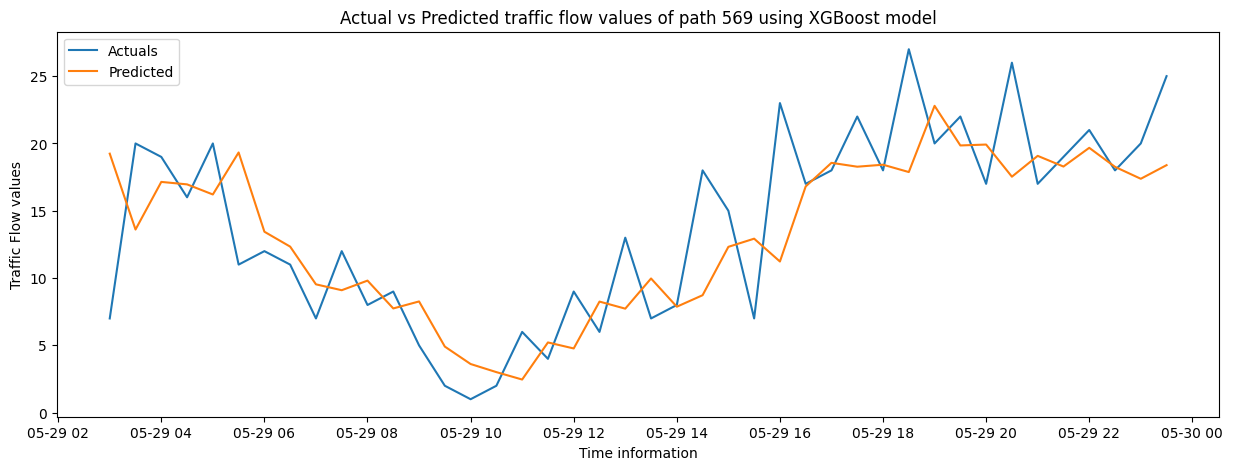

In [73]:
# Plot predictions from XGBoost model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 569 using XGBoost model')
plt.legend()
plt.plot()

[]

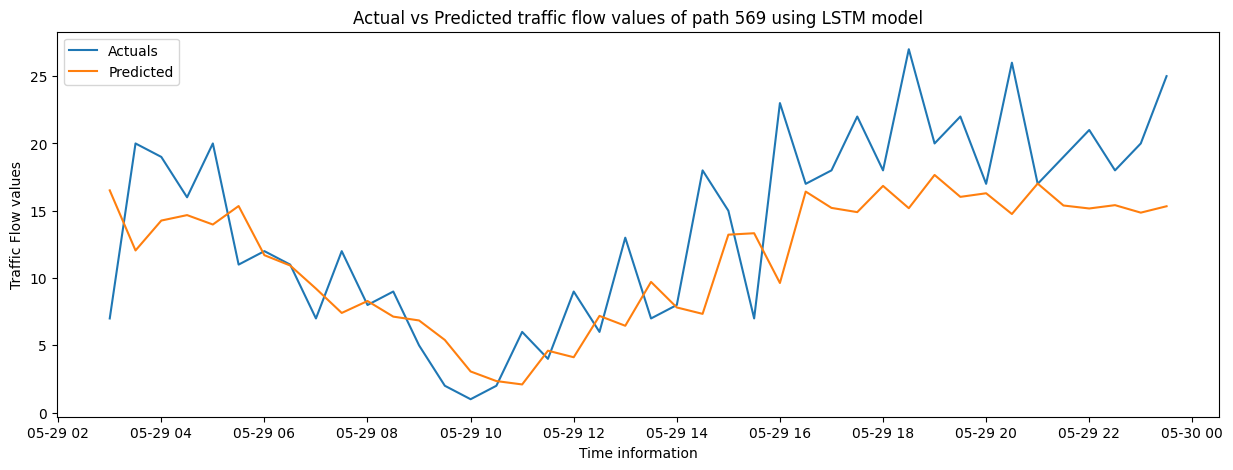

In [74]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 569 using LSTM model')
plt.legend()
plt.plot()

Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [75]:
# Create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [76]:
# Print dataframe with all model scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,2.293000,1.376555
1,LSTM,2.410743,1.422437


In [77]:
# Save the best model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow.model')